In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error



In [6]:
# Load the dataset
data = pd.read_csv('Uber-Jan-Feb-FOIL.csv')
data.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [3]:
# Display first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())



First 5 rows of the dataset:
  dispatching_base_number      date  active_vehicles  trips
0                  B02512  1/1/2015              190   1132
1                  B02765  1/1/2015              225   1765
2                  B02764  1/1/2015             3427  29421
3                  B02682  1/1/2015              945   7679
4                  B02617  1/1/2015             1228   9537


In [4]:
# Save dataset preview to file
data.head().to_csv("dataset_preview.csv", index=False)



In [5]:
# Check column names
print("Column names:", data.columns)



Column names: Index(['dispatching_base_number', 'date', 'active_vehicles', 'trips'], dtype='object')


In [6]:
# Standardize column names
data.rename(columns={'date': 'Date/Time'}, inplace=True)  # Renaming correctly
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format='%m/%d/%Y', errors='coerce')  # Convert to datetime



In [7]:
# Save cleaned dataset to file
data.to_csv("cleaned_dataset.csv", index=False)



In [8]:
# Data Preprocessing - Extracting time-based features
data['Hour'] = data['Date/Time'].dt.hour
data['Day'] = data['Date/Time'].dt.day
data['DayOfWeek'] = data['Date/Time'].dt.dayofweek
data['Month'] = data['Date/Time'].dt.month



In [9]:
# Save preprocessed dataset to file
data.to_csv("preprocessed_dataset.csv", index=False)



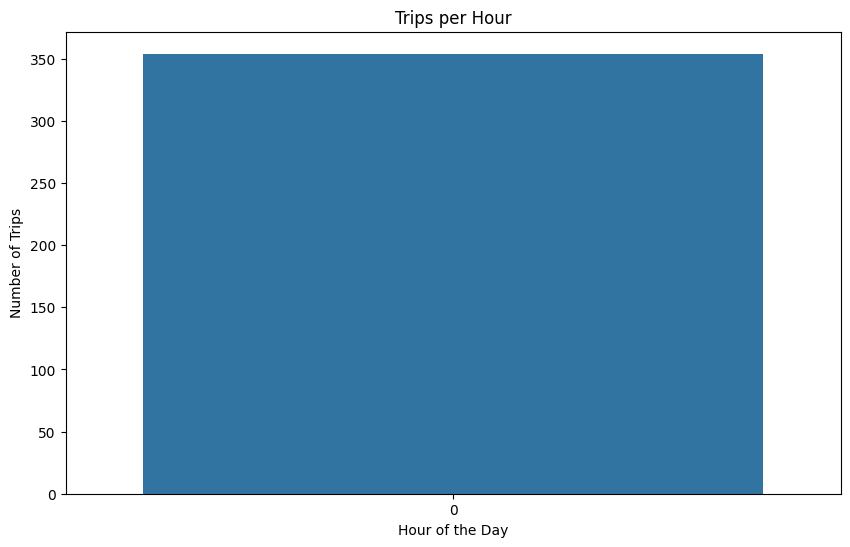

In [10]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.countplot(x=data['Hour'])
plt.title('Trips per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.savefig("trips_per_hour.png")  # Save plot
plt.show()



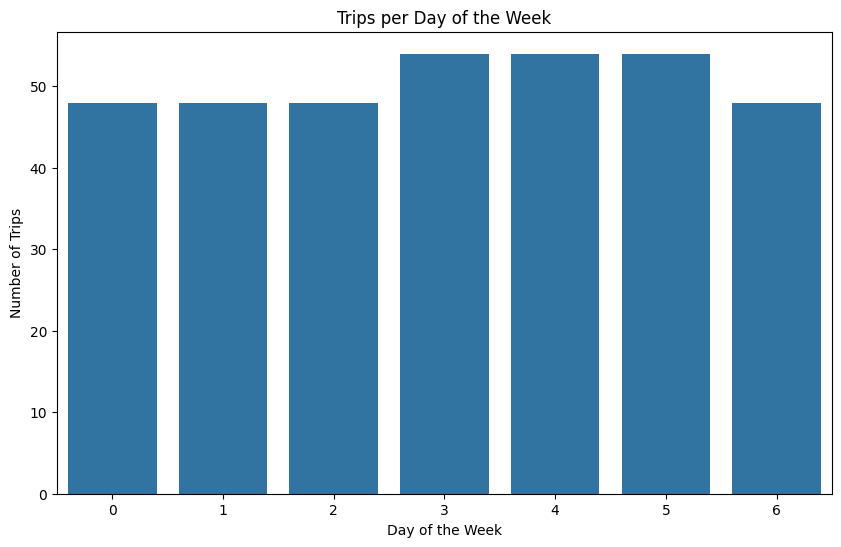

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x=data['DayOfWeek'])
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.savefig("trips_per_day_of_week.png")  # Save plot
plt.show()



In [16]:
print(data.columns)

Index(['Date/Time', 'active_vehicles', 'trips', 'Hour', 'Day', 'DayOfWeek',
       'Month', 'dispatching_base_number_B02598',
       'dispatching_base_number_B02617', 'dispatching_base_number_B02682',
       'dispatching_base_number_B02764', 'dispatching_base_number_B02765'],
      dtype='object')


In [23]:
# Feature Engineering
# Define features and target variable
X = data[['Hour', 'Day', 'DayOfWeek', 'Month', 'active_vehicles', 
          'dispatching_base_number_B02598', 'dispatching_base_number_B02617', 
          'dispatching_base_number_B02682', 'dispatching_base_number_B02764', 
          'dispatching_base_number_B02765']]  # Include all dispatching base columns
          
y = data['trips'] 



In [20]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [24]:
# Model Training & Optimization
tscv = TimeSeriesSplit(n_splits=5)



In [25]:
# XGBoost Model Training
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.3]}
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=tscv, scoring='neg_mean_absolute_percentage_error')
xgb_grid.fit(X_train, y_train)
xgb_pred = xgb_grid.best_estimator_.predict(X_test)



In [26]:
# Random Forest Model Training
rf_model = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=tscv, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.best_estimator_.predict(X_test)



In [27]:
# Gradient Boosting Model Training
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_params = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.3]}
gbr_grid = GridSearchCV(gbr_model, gbr_params, cv=tscv, scoring='neg_mean_absolute_percentage_error')
gbr_grid.fit(X_train, y_train)
gbr_pred = gbr_grid.best_estimator_.predict(X_test)



In [28]:
# Ensemble Model - Combining predictions
weights = np.array([0.368, 0.322, 0.310])
ensemble_pred = (weights[0] * xgb_pred + weights[1] * rf_pred + weights[2] * gbr_pred)



In [29]:
# Model Evaluation
evaluation_results = {
    "XGBoost MAPE": f"{mean_absolute_percentage_error(y_test, xgb_pred):.2%}",
    "Random Forest MAPE": f"{mean_absolute_percentage_error(y_test, rf_pred):.2%}",
    "Gradient Boosting MAPE": f"{mean_absolute_percentage_error(y_test, gbr_pred):.2%}",
    "Ensemble Model MAPE": f"{mean_absolute_percentage_error(y_test, ensemble_pred):.2%}"
}



In [30]:
# Print and save evaluation results
print("\nModel Evaluation Results:")
for model, score in evaluation_results.items():
    print(f"{model}: {score}")

pd.DataFrame.from_dict(evaluation_results, orient='index').to_csv("model_evaluation.csv")




Model Evaluation Results:
XGBoost MAPE: 7.63%
Random Forest MAPE: 8.35%
Gradient Boosting MAPE: 9.40%
Ensemble Model MAPE: 7.21%


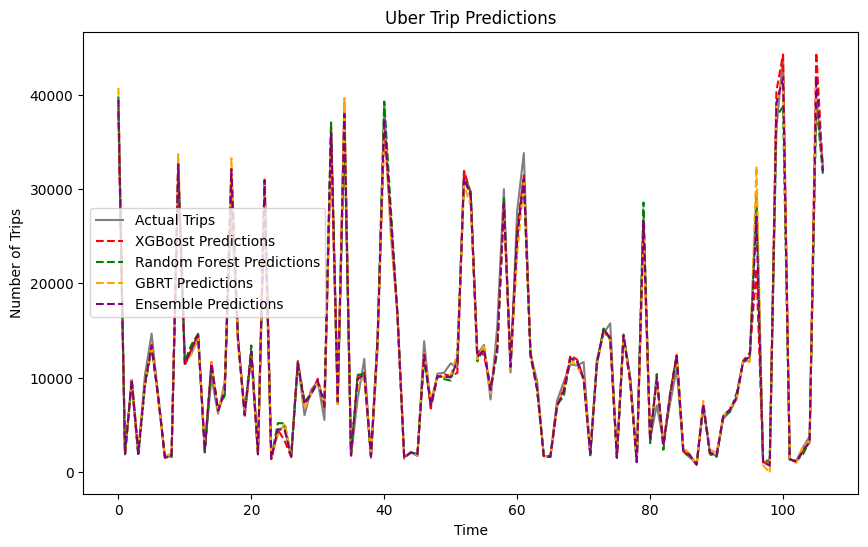

In [31]:
# Visualization of Predictions
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Trips', color='gray')
plt.plot(xgb_pred, label='XGBoost Predictions', linestyle='--', color='red')
plt.plot(rf_pred, label='Random Forest Predictions', linestyle='--', color='green')
plt.plot(gbr_pred, label='GBRT Predictions', linestyle='--', color='orange')
plt.plot(ensemble_pred, label='Ensemble Predictions', linestyle='--', color='purple')
plt.legend()
plt.title('Uber Trip Predictions')
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.savefig("uber_trip_predictions.png")  # Save plot
plt.show()



In [32]:
import joblib

# Save trained models
joblib.dump(xgb_grid.best_estimator_, 'xgb_model.pkl')  # XGBoost
joblib.dump(rf_grid.best_estimator_, 'rf_model.pkl')  # Random Forest
joblib.dump(gbr_grid.best_estimator_, 'gbr_model.pkl')  # Gradient Boosting

['gbr_model.pkl']